In this notebook we will extract identified objects from the YOLO model's predictions, and apply different super-resolution techniques to make the objects look sharper.

# Load test images from combined HRSID/SADD dataset, get YOLO predictions and extract objects boxes:

In [2]:
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [3]:
# Modify as necessary
root_dir = r"/Users/alexm/Senior-Design"

In [4]:
# Paths to test images and labels
combined_datasets_dir = os.path.join(root_dir, "datasets", "HRSID_SADD_Combined")
combined_datasets_test_images_dir = os.path.join(combined_datasets_dir, "test", "images")
combined_datasets_test_labels_dir = os.path.join(combined_datasets_dir, "test", "labels")

In [5]:
# Load trained model
model_path = os.path.join(root_dir, "runs", "detect", "hrsid_sadd_combined_detection7", "weights", "best.pt")
model = YOLO(model_path)

In [6]:
# Load test images until we get 16 which have identified objects
test_image_names = os.listdir(combined_datasets_test_images_dir)
objects = []
idx = 0
while len(objects) < 16 and idx < len(test_image_names):
    image_path = os.path.join(combined_datasets_test_images_dir, test_image_names[idx])
    pred = model([image_path])
    # Check if any predictions were made
    if pred[0].boxes.conf.shape[0] > 0:
        objects.append(pred)
    idx += 1


0: 224x224 (no detections), 29.6ms
Speed: 0.6ms preprocess, 29.6ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 26.1ms
Speed: 0.2ms preprocess, 26.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 ship, 26.7ms
Speed: 0.2ms preprocess, 26.7ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 28.2ms
Speed: 0.2ms preprocess, 28.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 25.8ms
Speed: 0.2ms preprocess, 25.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 26.1ms
Speed: 0.2ms preprocess, 26.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 1 ship, 34.5ms
Speed: 0.2ms preprocess, 34.5ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 (no detections), 28.4ms
Speed: 0.2ms preprocess, 28.4ms inference, 0.1ms po

In [7]:
# Function to convert xywh (centered at (x,y)) to coords that we can plot in plt
def xywh_to_corner_box_coords(x, y, w, h):
    lower_left_x = x - w / 2
    lower_left_y = y - h / 2
    return lower_left_x, lower_left_y

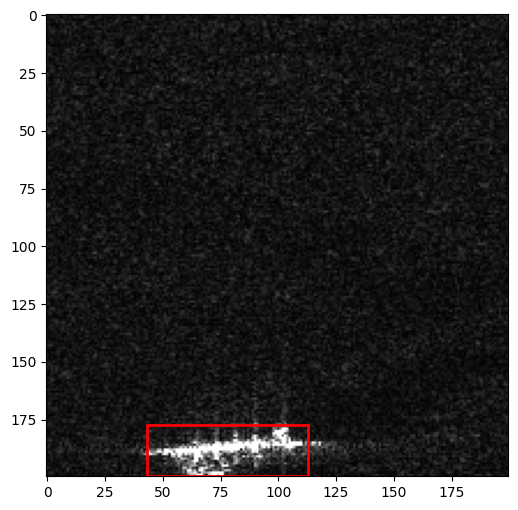

In [8]:
# Plot first image with bounding box drawn over identified object
fig, ax = plt.subplots(figsize=(6,6))

img_idx = 0
sample_obj = objects[img_idx][0]
sample_obj_img = sample_obj.orig_img
sample_obj_box_xywh = sample_obj.boxes.xywh[0]

ax.imshow(sample_obj_img)

width = sample_obj_box_xywh[2]
height = sample_obj_box_xywh[3]
corner_x, corner_y = xywh_to_corner_box_coords(sample_obj_box_xywh[0], sample_obj_box_xywh[1], width, height)
rect = patches.Rectangle((corner_x, corner_y), width, height, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()

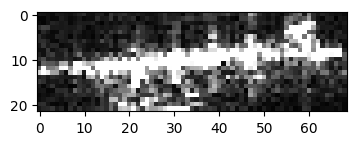

In [9]:
# Plot just identified object from first image (sized up by whatever matplotlib uses for interpolation)
fig, ax = plt.subplots(figsize=(4,4))

sample_obj_identified = sample_obj_img[int(corner_y):int(corner_y+height), int(corner_x):int(corner_x+width)]
ax.imshow(sample_obj_identified)
plt.show()

In [10]:
low_res_obj_patches_path = os.path.join(root_dir, "sr_testing", "low_res_obj_patches")
low_res_images_path = os.path.join(root_dir, "sr_testing", "low_res_images")

In [11]:
# Save all low-res images in a new folder
for img_idx in range(len(objects)):
    # Save every identified object patch
    for obj_idx in range(objects[img_idx][0].boxes.cls.shape[0]):

        obj_box_xywh = objects[img_idx][0].boxes.xywh[obj_idx]
        width = obj_box_xywh[2]
        height = obj_box_xywh[3]
        corner_x, corner_y = xywh_to_corner_box_coords(obj_box_xywh[0], obj_box_xywh[1], width, height)
        obj_patch = objects[img_idx][0].orig_img[int(corner_y):int(corner_y+height), int(corner_x):int(corner_x+width)]

        obj_patch_img = Image.fromarray(obj_patch)
        obj_save_path = os.path.join(low_res_obj_patches_path, "img_idx" + str(img_idx) + "obj_idx" + str(obj_idx) + ".png")
        obj_patch_img.save(obj_save_path)

    full_img = Image.fromarray(objects[img_idx][0].orig_img)
    full_img_save_path = os.path.join(low_res_images_path, "img_idx" + str(img_idx) + ".png")
    full_img.save(full_img_save_path)

## Apply pre-trained SwinIR, ESRGAN

In [12]:
import subprocess
import re
import shutil

In [ ]:
# Apply SwinIR (4x) to full images with potentially multiple objects, use KAIR testing script
kair_path = os.path.join(root_dir, "KAIR")
swin_ir_model_path = os.path.join(root_dir, "sr_models", "003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth")
result = subprocess.run(
    ['python', os.path.join(kair_path, "main_test_swinir.py"), 
     "--task", "real_sr", "--model_path", swin_ir_model_path, 
     "--folder_lq", low_res_images_path,
     "--scale", "4",
     "--training_patch_size", "64"],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)

/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading model from /Users/alexm/Senior-Design/sr_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth
Testing 0 img_idx0            
Testing 1 img_idx1            
Testing 2 img_idx10           
Testing 3 img_idx11           
Testing 4 img_idx12           
Testing 5 img_idx13           
Testing 6 img_idx

In [ ]:
# Apply SwinIR (4x) to full images with potentially multiple objects, use KAIR testing script
kair_path = os.path.join(root_dir, "KAIR")
swin_ir_model_path = os.path.join(root_dir, "sr_models", "003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth")
result = subprocess.run(
    ['python', os.path.join(kair_path, "main_test_swinir.py"), 
     "--task", "real_sr", "--model_path", swin_ir_model_path, 
     "--folder_lq", low_res_images_path,
     "--scale", "4",
     "--training_patch_size", "64",
     "--large_model"],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)

/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading model from /Users/alexm/Senior-Design/sr_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth
Testing 0 img_idx0            
Testing 1 img_idx1            
Testing 2 img_idx10           
Testing 3 img_idx11           
Testing 4 img_idx12           
Testing 5 img_idx13           
Testing 6 img

Note: The below code uses the basicsr package for some image processing, which is not immediately compatible with more recent PyTorch versions. If an error like "/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/basicsr/data/degradations.py", line 8, in <module>
    ```from torchvision.transforms.functional_tensor import rgb_to_grayscale```
ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'
is thrown, then change the line to ```from torchvision.transforms.functional import rgb_to_grayscale```


In [13]:
# Apply ESRGAN to full images
esrgan_path = os.path.join(root_dir, "super_resolution_testing", "Real-ESRGAN")
esrgan_model_path = os.path.join(root_dir, "sr_models", "RealESRGAN_x4plus.pth")
result = subprocess.run(
    ['python', os.path.join(esrgan_path, "inference_realesrgan.py"), 
     "-n", "RealESRGAN_x4plus",
     "--input", low_res_images_path,
     "-s", "4", "--fp32",
     "--output", os.path.join(root_dir, "super_resolution_testing", "results", "esrgan")],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)



Testing 0 img_idx0
Testing 1 img_idx1
Testing 2 img_idx10
Testing 3 img_idx11
Testing 4 img_idx12
Testing 5 img_idx13
Testing 6 img_idx14
Testing 7 img_idx15
Testing 8 img_idx2
Testing 9 img_idx3
Testing 10 img_idx4
Testing 11 img_idx5
Testing 12 img_idx6
Testing 13 img_idx7
Testing 14 img_idx8
Testing 15 img_idx9



### Visualize results from different models for a few images

In [14]:
import matplotlib.image as mpimg

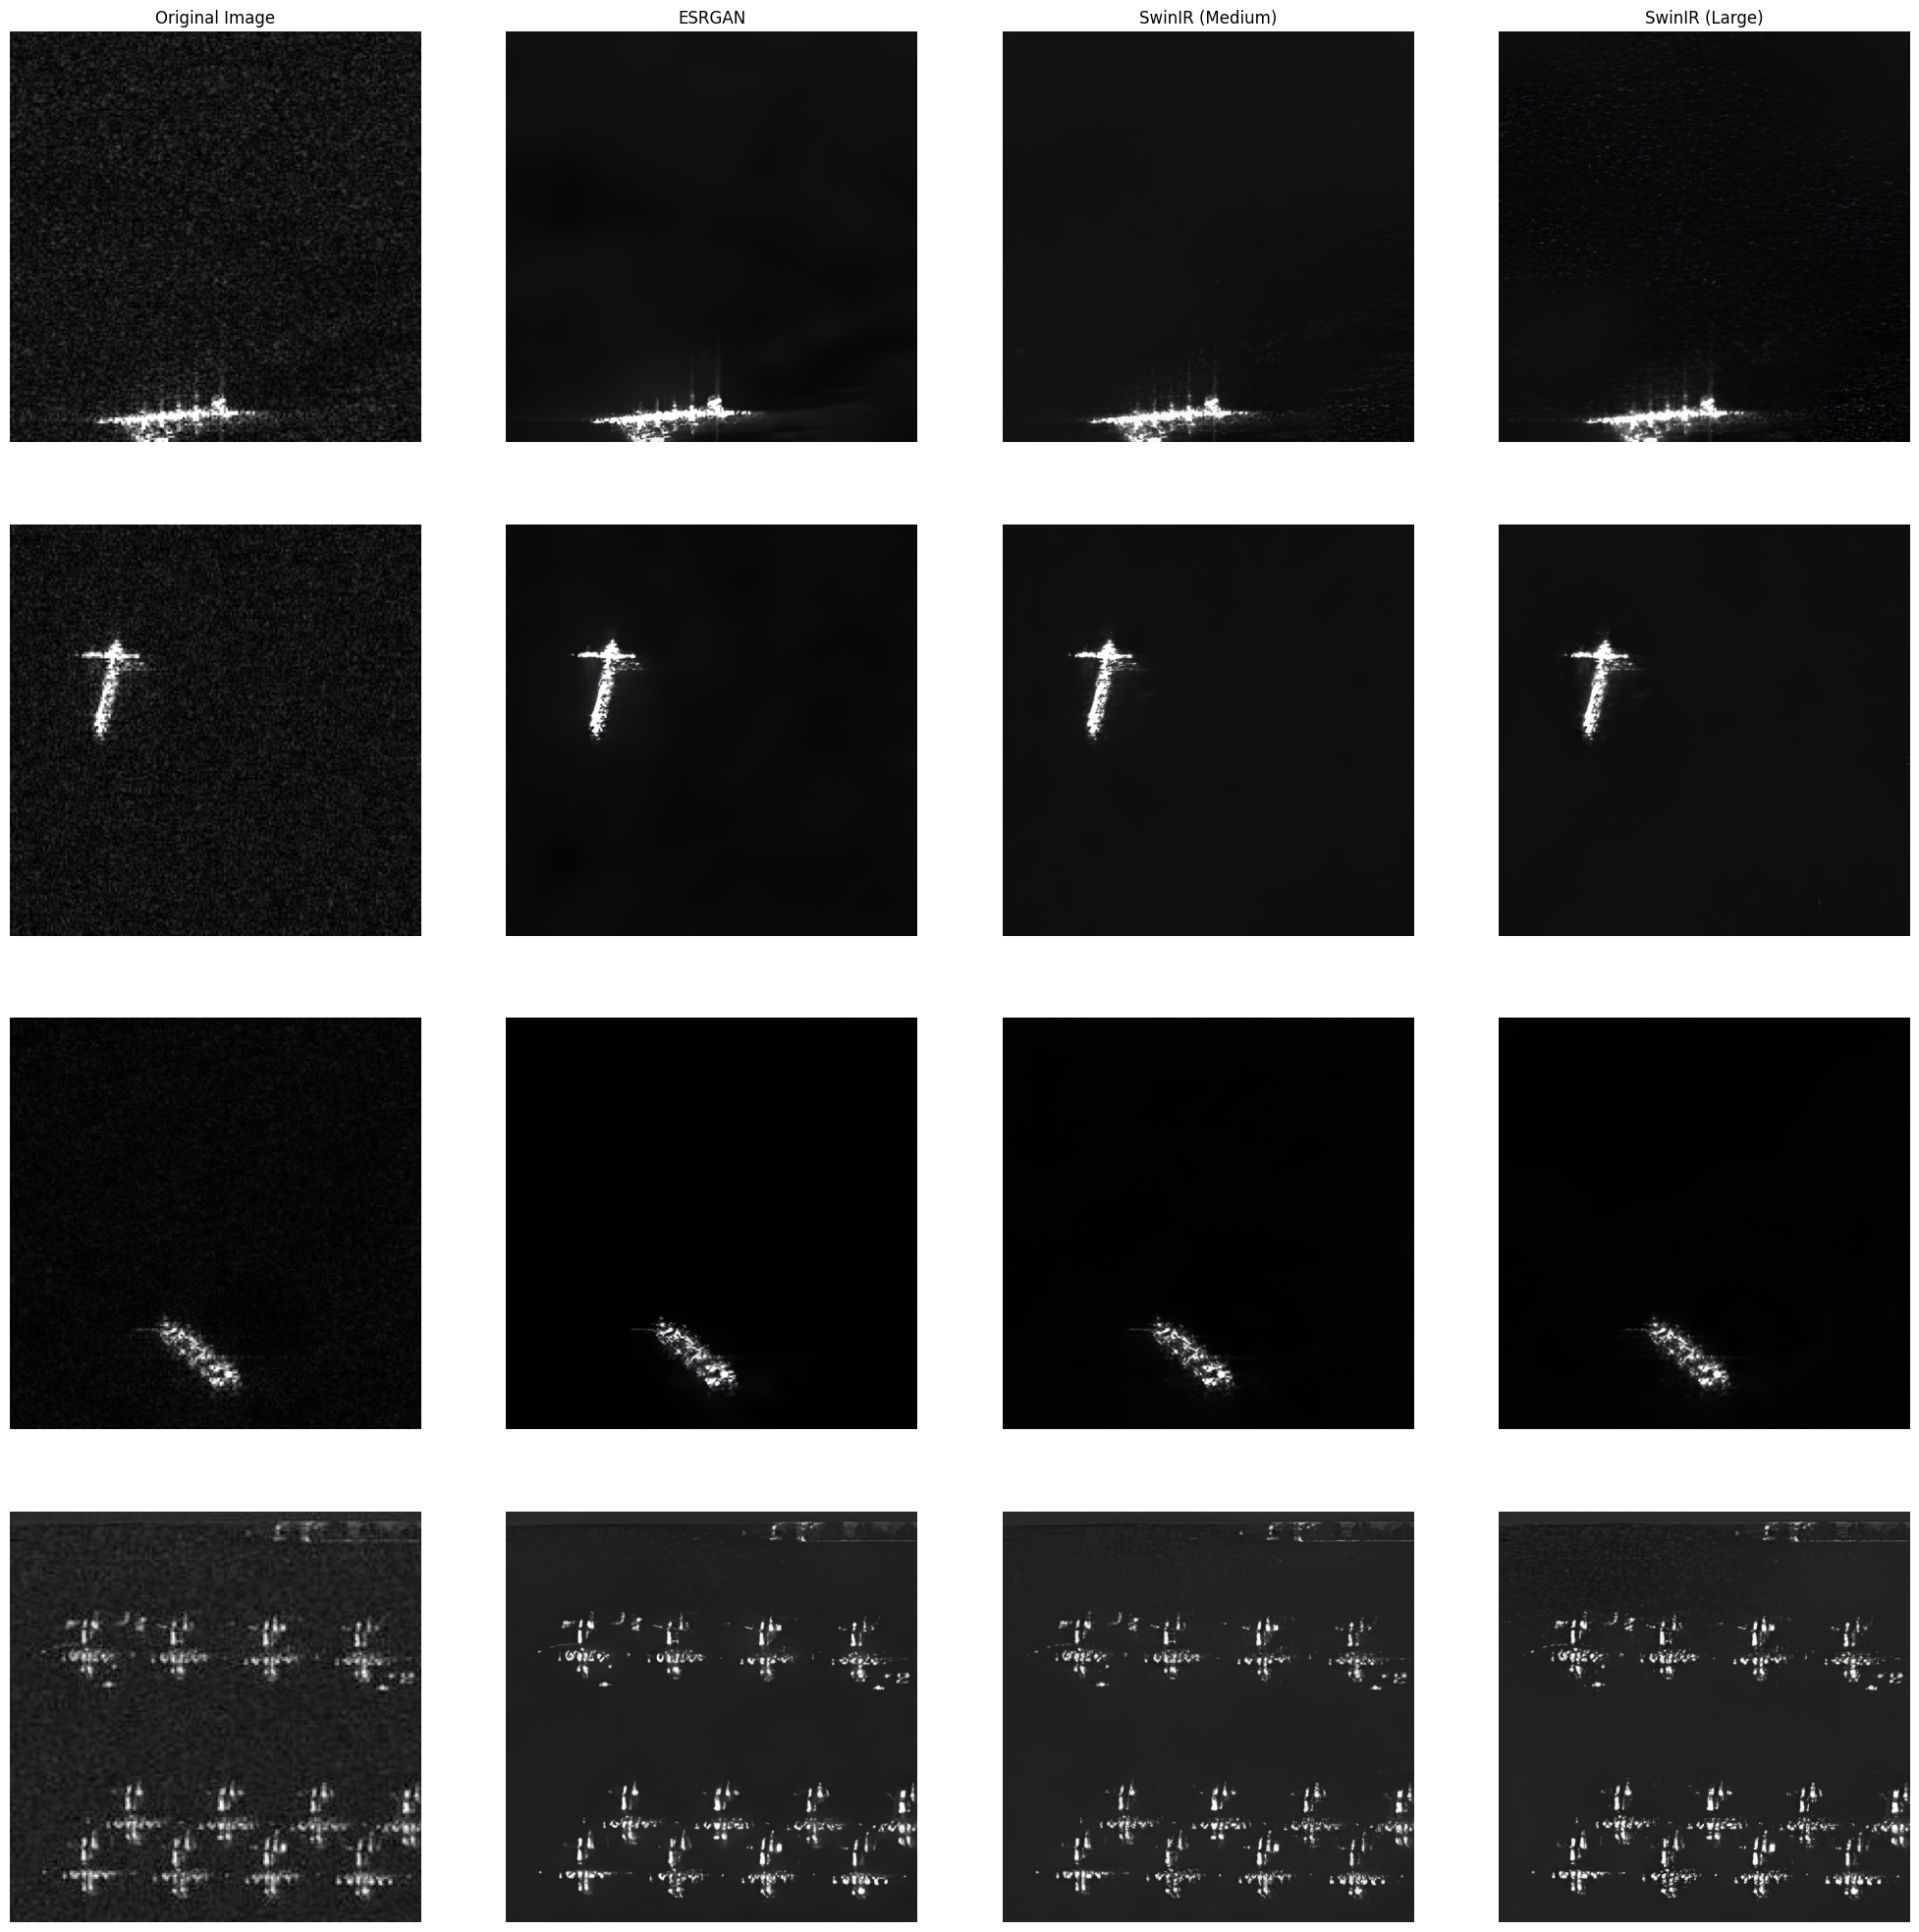

In [18]:
original_img_dir = os.path.join(root_dir, "sr_testing", "low_res_images")
results_dir = os.path.join(root_dir, "sr_testing", "results")

img_idxs = ["0", "2", "4", "15"]
num_cols = 4
num_images = len(img_idxs)

fig, axs = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(25,25))
axs[0, 0].axis("off")
axs[0, 0].set_title("Original Image")
col_titles = ["Original Image", "ESRGAN", "SwinIR (Medium)", "SwinIR (Large)"]
for col, title in zip(range(num_cols), col_titles):
    axs[0, col].set_title(title)
    for row, img_idx in enumerate(img_idxs):
        axs[row, col].axis("off")
        if col == 0:
            original_img_path = os.path.join(original_img_dir, "img_idx" + img_idx + ".png")
            im = mpimg.imread(original_img_path)
            axs[row, col].imshow(im)
        elif col == 1:
            esrgan_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "esrgan", "img_idx" + img_idx + "_out.png")
            im = mpimg.imread(esrgan_img_path)
            axs[row, col].imshow(im)
        elif col == 2:
            #swin_ir_medium_img_path = os.path.join(results_dir, "swin_ir_x4", "full_img", "img_idx" + img_idx + "_SwinIR.png")
            swin_ir_medium_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "swinir_real_sr_x4", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_medium_img_path)
            axs[row, col].imshow(im)
        elif col == 3:
            swin_ir_large_img_path = os.path.join(results_dir, "swin_ir_large_x4", "full_img", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_large_img_path)
            axs[row, col].imshow(im)

plt.axis('off')
plt.show()

## View results from fine-tuned model

In [ ]:
# Apply SwinIR (4x) to full images with potentially multiple objects, use KAIR testing script instead
kair_path = os.path.join(root_dir, "KAIR")
swin_ir_model_path = os.path.join(root_dir, "sr_models", "003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN_finetuned.pth")
save_path = os.path.join(root_dir, "super_resolution_testing", "results", "swinir_x4_finetuned")
result = subprocess.run(
    ['python', os.path.join(kair_path, "main_test_swinir.py"), 
     "--task", "real_sr", "--model_path", swin_ir_model_path, 
     "--folder_lq", low_res_images_path,
     "--scale", "4",
     "--training_patch_size", "64",
     "--save_dir", save_path],
    capture_output=True,
    text=True
)
print(result.stderr + "\n")
print(result.stdout)

/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/alexm/miniconda3/envs/senior_design/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


loading model from /Users/alexm/Senior-Design/sr_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN_finetuned.pth
Testing 0 img_idx0            
Testing 1 img_idx1            
Testing 2 img_idx10           
Testing 3 img_idx11           
Testing 4 img_idx12           
Testing 5 img_idx13           
Testing

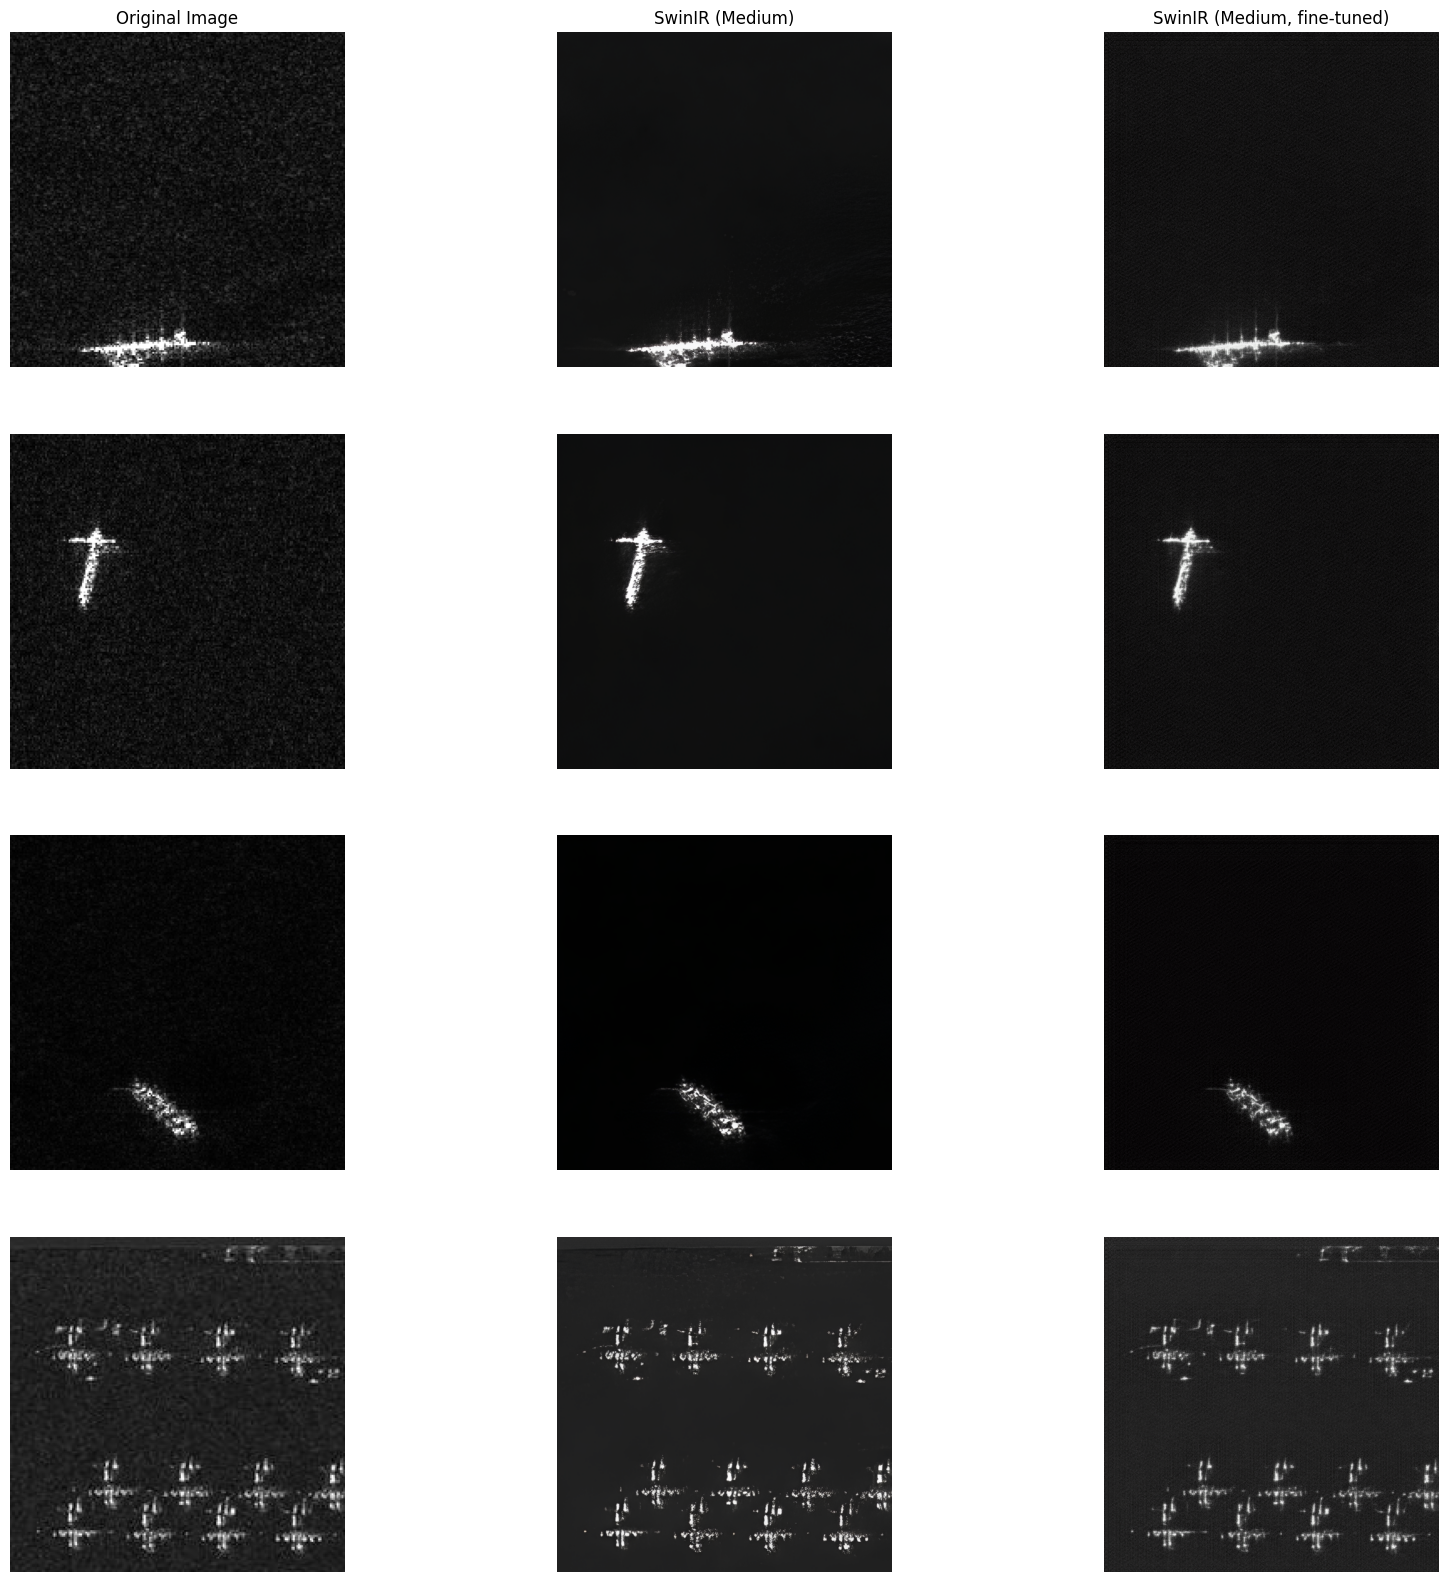

In [22]:
original_img_dir = os.path.join(root_dir, "sr_testing", "low_res_images")
results_dir = os.path.join(root_dir, "sr_testing", "results")

img_idxs = ["0", "2", "4", "15"]
num_cols = 3
num_images = len(img_idxs)

fig, axs = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(20,20))
axs[0, 0].axis("off")
axs[0, 0].set_title("Original Image")
col_titles = ["Original Image", "SwinIR (Medium)", "SwinIR (Medium, fine-tuned)"]
for col, title in zip(range(num_cols), col_titles):
    axs[0, col].set_title(title)
    for row, img_idx in enumerate(img_idxs):
        axs[row, col].axis("off")
        if col == 0:
            original_img_path = os.path.join(original_img_dir, "img_idx" + img_idx + ".png")
            im = mpimg.imread(original_img_path)
            axs[row, col].imshow(im)
        elif col == 1:
            #swin_ir_medium_img_path = os.path.join(results_dir, "swin_ir_x4", "full_img", "img_idx" + img_idx + "_SwinIR.png")
            swin_ir_medium_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "swinir_real_sr_x4", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_medium_img_path)
            axs[row, col].imshow(im)
        elif col == 2:
            swin_ir_medium_finetuned_img_path = os.path.join("/Users", "alexm", "Senior-Design", "super_resolution_testing", "results", "swinir_x4_finetuned", "img_idx" + img_idx + "_SwinIR.png")
            im = mpimg.imread(swin_ir_medium_finetuned_img_path)
            axs[row, col].imshow(im)

plt.axis('off')
plt.show()